# Данные

Данные в файле covid_flow.pkl
Данные включают поток пациентов с подтвержденным COVID-19 в ковидные стационары НИМЦ
Алмазова, Санкт-Петербург.

Датасет включает 1992 случая стационарного лечения COVID-19. Данные включают

•
Многомерные временные ряды, описывающие состояние пациента (интервал неделя)

•
План лечения (препараты и процедуры) для каждого пациента

•
Исходы лечения

Процесс стационарного лечения включает в себя два подпроцесса – контролирующий и контролируемый. 

Контролирующий –
назначение препаратов и процедур. 
Контролируемый – процесс изменения состояния пациентов.

Процесс лечения
включает в себя контролирующий процесс (назначение препарат и процедур) и контролируемый
процесс (процесс изменения состояния пациентов)

_stat_control – стационарные признаки, которые описывают контролирующий
процесс и не меняются (в covid_flow это бинарные признаки включения 1 или
невключения 0 препарата в план лечения)

_dinam_control – динамические признаки, которые описывают контролирующий
процесс и меняются (в covid_flow это бинарные признаки включения 1 или
невключения 0 процедуры в план лечения)

_stat_fact – стационарные признаки, которые описывают контролируемый процесс
и не меняются (в covid_flow это признаки, описывающие пациентов, пол, возраст, и
все остальное что не меняется)

_dinam_fact – динамические признаки, которые описывают контролирующий
процесс и меняются (в covid_flow это признаки описывающие состояние
пациентов, например температура, % поражения легких и другое)

t_point – индикатор временного интервала. Вся длительность процесса разбита на
равные интервалы времени, t_point – метка интервала.

end_epizode – индикатор конца процесса, 0 – процесс лечения не окончен в
данном t_point, 1 – окончен

case (index) – уникальный идентификатор наблюдения (процесса), пример –
«GACAk+Q»

long_observation_tar – длинна процесса

current_process_duration – текущая длинна процесса (на момент t_point)

outcome_tar – исход лечения, 1- летальный, 0 – выздоровление.

# Прогноза значения индикатора пациента
Прогноз проходит в следующем периоде по иформации о
текущем состоянии и предыдущих состояниях. 
Таргеты – признаки с префиксами
_dinam_fact. 
Факторы – все признаки кроме тех что с префиксами _tar. 

1) Для начала нужен литературный обзор существующих методов. 
2) Далее берешь пару существующих методов, пробуешь применить и переложить на данные. Хочется чтобы были попробованны рекурентные нейронные сети, и AutoML подход Fedot
)(https://github.com/nccr-itmo/FEDOT), но в целом ограничений на методы нет. 
3) На выходе нужен класс, который умеет принимать информацию о прошлых состояниях пациента, и
прогнозировать следующее. Читаемость и чистота кода крайне приветствуется. 

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from time import time
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
import pickle
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from keras.metrics import RootMeanSquaredError

In [123]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df.set_index(["case", "t_point"], inplace=True)
df.sort_index()


омепразол_stat_control  надропарин кальция_stat_control  \
case    t_point                                                            
GACAAcY 0                             1                                1   
        1                             1                                1   
        2                             1                                1   
        3                             1                                1   
GACAAnf 0                             1                                1   
...                                 ...                              ...   
GACBB;O 0                             0                                0   
        1                             0                                0   
GACXAAB 0                             1                                0   
        1                             1                                0   
        2                             1                                0   

                 эзомепразол_stat_control  амлодипин_stat_control  \
case    t_point                                                     
GACAAcY 0                               1                       1   
        1                               1                       1   
        2                               1                       1   
        3                               1                       1   
GACAAnf 0                               1                       1   
...                                   ...                     ...   
GACBB;O 0                               0                       1   
        1                               0                       1   
GACXAAB 0                               1                       1   
        1                               1                       1   
        2                               1                       1   

                 амброксол_stat_control  домперидон_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                             1                        1   
GACAAnf 0                             1                        1   
...                                 ...                      ...   
GACBB;O 0                             1                        0   
        1                             1                        0   
GACXAAB 0                             0                        1   
        1                             0                        1   
        2                             0                        1   

                 меброфенин_stat_control  технеций_stat_control  \
case    t_point                                                   
GACAAcY 0                              1                      1   
        1                              1                      1   
        2                              1                      1   
        3                              1                      1   
GACAAnf 0                              1                      1   
...                                  ...                    ...   
GACBB;O 0                              0                      0   
        1                              0                      0   
GACXAAB 0                              1                      1   
        1                              1                      1   
        2                              1                      1   

                 мометазон_stat_control  бисопролол_stat_control  ...  \
case    t_point                                                   ...   
GACAAcY 0                             1                        1  ...   
        1                             1                        1  ...   
        2                             1                        1  ...   
        

# Check the data

Divide dataset to treatment and pynamic parameters

In [124]:
stat_fact_df = df.iloc[:,0:29]
stat_fact_df = stat_fact_df.sort_values(["case", "t_point"])

But initially check if treatment strategy has been changed? No. But found 22 records with no treatments at all.

In [125]:
non_typical_treatments = []
for i in stat_fact_df.index.levels[0]:
    means = stat_fact_df.loc[(i)].mean()
    if (set(means.unique()) != set([0,1])):
        non_typical_treatments.append([i, set(means.unique())])
non_typical_treatments

[['GACAJуЭ', {0.0}],
 ['GACAKАF', {0.0}],
 ['GACALрЫ', {0.0}],
 ['GACAT&H', {0.0}],
 ['GACA^МЮ', {0.0}],
 ['GACAb!2', {0.0}],
 ['GACAjц>', {0.0}],
 ['GACAjщ[', {0.0}],
 ['GACAjюc', {0.0}],
 ['GACAjяв', {0.0}],
 ["GACAk'5", {0.0}],
 ['GACAk){', {0.0}],
 ['GACAk+ц', {0.0}],
 ['GACAk.3', {0.0}],
 ['GACAm7g', {0.0}],
 ['GACAm?о', {0.0}],
 ['GACAmBц', {0.0}],
 ['GACAmCх', {0.0}],
 ['GACAmPф', {0.0}],
 ['GACAm^и', {0.0}],
 ['GACAmnW', {0.0}],
 ['GACAmЩП', {0.0}]]

*inof_df* static information about patient and treatment

In [126]:
info_df = pd.DataFrame()
info_df["age_stat_fact"] = df["age_stat_fact"]
info_df["outcome_tar"] = df["outcome_tar"]
info_df["long_observation_tar"] = df["long_observation_tar"]
info_df["admission_date"] = df["admission_date"]
info_df["duration_before_start"] = df["current_process_duration"]
info_df["process_stages"] = df["process_stages"]
periods = info_df.groupby("case").count()["age_stat_fact"]
info_df = info_df.groupby("case").first()
info_df["periods_stat_fact"] = periods
info_df

,age_stat_fact,outcome_tar,long_observation_tar,admission_date,duration_before_start,process_stages,periods_stat_fact
case,,,,,,,
GACAAcY,81,0,22,2021-01-29,3,2,4
GACAAnf,73,0,6,2020-06-06,3,1_2,2
GACABsT,59,0,14,2020-12-30,3,2,3
GACACKP,71,0,15,2021-01-26,3,2,3
GACADBj,37,0,20,2021-02-19,3,2,4
...,...,...,...,...,...,...,...
GACBAхz,25,0,14,2020-12-25,3,2,3
GACBAщн,37,0,15,2021-01-14,3,2,3
GACBB-В,70,0,1,2020-12-22,3,2,1


dinam_fact_df with dinamic parameters changed during observation. TARGETS!!

In [127]:
dinam_fact_df = df.iloc[:,29:42]
dinam_fact_df = dinam_fact_df.sort_values(["case", "t_point"])

*dynam_control_df* procedures during observation. Unlike medicine, procedures has been changed during observation, so parameters pedends on time. 

In [128]:
dinam_control_df = df.iloc[:,43:47]
dinam_control_df = dinam_control_df.sort_values(["case", "t_point"])

### EDA

Average observation period is 14 days. We can use it in input for LSTM

In [129]:
display(f"Average observation long is {info_df['long_observation_tar'].mode()[0]}")

'Average observation long is 14'

In [130]:
info_df["outcome_tar"].value_counts()

0    1860
1     132
Name: outcome_tar, dtype: int64

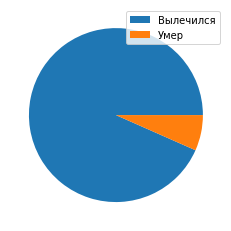

In [131]:
plt.pie(info_df["outcome_tar"].value_counts())
plt.legend(["Вылечился", "Умер"])
plt.show()

### Data preparation

Divide observations on train and test parts. We take some part as train period and next as test period. So we have X as (, WINDOW, PARAMS) and y (PARAMS)

In [132]:
#module divides on X [[1, 2, 3, 4]] and y [5]
WINDOW = 3
PARAMS_LENGTH = 13

def df_to_X_y(df, window_per):
    X = []
    y = []
    for i in df.index.levels[0]:
        i_l = df.loc[(i)].index
        if (len(i_l) < window_per+1):
            continue
        X.append(df.loc[(i, 0):(i, window_per-1)].to_numpy(dtype="float64"))
        y.append(df.loc[(i, window_per)].to_numpy(dtype="float64"))
    return X, y

X, y = df_to_X_y(dinam_fact_df, WINDOW)
X_to_sc = np.array(X).reshape(-1, PARAMS_LENGTH)
y = np.array(y)

Impute NaN values using MICE methods with Linear regression as estimator 

In [133]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
imp = IterativeImputer(estimator=LinearRegression(),
     missing_values=np.nan, max_iter=10, imputation_order='roman', random_state=0)
X_ex=imp.fit_transform(X_to_sc)
y_ex=imp.fit_transform(y)


Norm data by Standart Scaler and divide and train test parts

In [134]:
scal_model = StandardScaler().fit(X_ex)
print(scal_model.mean_)
X_scaled = scal_model.transform(X_ex)
y_scaled = scal_model.transform(y_ex)
X_scaled_divided = np.array(X_scaled).reshape(-1, WINDOW, PARAMS_LENGTH)
y_scaled_divided = np.array(y_scaled).reshape(-1, PARAMS_LENGTH)

[3.66560030e+01 1.90888692e+00 4.15752746e+01 7.24846030e+01
 1.98050345e+01 1.01508401e+01 9.58943163e+00 2.53374527e-01
 1.85424094e+01 9.81132075e-02 3.45157233e+00 3.47227775e+02
 1.46609349e+01]


In [135]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_divided, y_scaled_divided)
X_train.shape

(397, 3, 13)

### Training

Start with one layer RNN size 13

1. Simple RNN with h size 13

In [138]:
BATCH_SIZE=1
model = Sequential()
model.add(Input((None, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(SimpleRNN(PARAMS_LENGTH, activation="relu", return_sequences=False))
model_simple_rnn_13 = model
model_simple_rnn_13.compile(loss="mse", metrics=[RootMeanSquaredError()])
model_simple_rnn_13.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (1, 13)                   351       
                                                                 
Total params: 351
Trainable params: 351
Non-trainable params: 0
_________________________________________________________________


Lets show learning history for the model

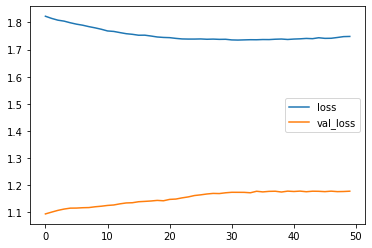

In [142]:
history = model_simple_rnn_13.fit(X_train, y_train, epochs=50, validation_split=0.1, batch_size=BATCH_SIZE, shuffle=False, verbose=0)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])

In [143]:
print(model_simple_rnn_13.evaluate(X_test, y_test, batch_size=BATCH_SIZE))
print(model_simple_rnn_13.metrics_names)


133/133 [==============================] - 0s 911us/step - loss: 0.6168 - root_mean_squared_error: 0.7853
[0.6167545318603516, 0.7853371500968933]
['loss', 'root_mean_squared_error']


Lets show on table what we have predicted:

In [164]:
SAMPLE_N = 0
X_test_0 = scal_model.transform(X_test[SAMPLE_N])
y_pred_0 = model_simple_rnn_13.predict(np.array([X_test_0]*BATCH_SIZE), verbose=0)
y_pred_0_inv = scal_model.inverse_transform(y_pred_0)
predicted_values = [float("{:0.2f}".format(x)) for x in y_pred_0_inv[SAMPLE_N]]
real_values = [float("{:0.2f}".format(x)) for x in scal_model.inverse_transform([y_test[SAMPLE_N]])[0]]
df = pd.DataFrame({dinam_fact_df.columns[i]:[real_values[i], predicted_values[i]] for i in range(len(real_values))}, index=["predicted", "real"])
df

1/1 [==============================] - 0s 17ms/step
Real values


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
predicted,36.52,0.72,19.80,69.00,17.00,8.43,7.30,0.09,10.30,0.0,3.00,308.35,20.10
real,36.66,1.91,41.58,72.48,19.81,10.15,12.97,0.25,236.73,0.1,6.99,347.23,14.66
